# Case Study 1

##### imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    make_scorer,
    log_loss
)

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import warnings

# My own functions 
import sys
sys.path.append('./functions')
from home_brew import (
    logistic_regression_diagnostic_plots,
    diagnostic_plots,
    calculate_vif,
    remove_high_vif_features,
    evaluate,
    plot_sensitivity_specificity,
    aic_scorer,
    select_model_by_aic,
    view_logistic_regression_coefficients,
    calculate_cooks_distance
)

## Data Cleaning

In [2]:
# Load the dataset
df_bank = pd.read_csv('./data/bank-additional.csv', sep=';', na_values=['unknown'])
df_bank.dropna(inplace=True)

# Convert 'pdays' to a categorical column based on specified bins
df_bank['pdays_cat'] = pd.cut(
    df_bank['pdays'], 
    bins=[-float('inf'), 0, 7, 14, 21, float('inf')],
    labels=[
        'NEVER CALLED OR ONLY CALLED ONCE',
        '0-1 WEEKS BETWEEN LAST 2 CALLS',
        '1-2 WEEKS BETWEEN LAST 2 CALLS',
        '2-3 WEEK BETWEEN LAST 2 CALLS',
        'MORE THAN 3 WEEKS BETWEEN LAST 2 CALLS'
    ]
)

# Convert the target variable 'y' to binary (1 for 'yes', 0 for 'no')
df_bank['y'] = df_bank['y'].map(lambda x: 1 if x.lower() == 'yes' else 0)

# Drop columns that will not be used in the VIF calculation
df_bank.drop(
    columns=[
        'default',
        'duration',
        'pdays',
        'month',
        'day_of_week'
    ],
    inplace=True
)

# Convert categorical columns to dummy variables, excluding the first category to avoid multicollinearity
categorical_cols = ["job", "marital", "education", "housing", "loan", "contact", "poutcome", "pdays_cat"]
df_bank = pd.get_dummies(df_bank, columns=categorical_cols, drop_first=True)

## REMOVE CORRELATED VARIABLES


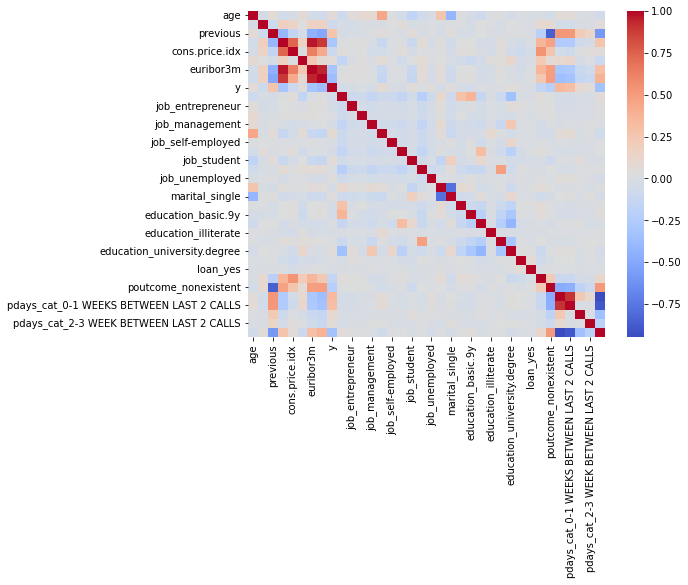

In [3]:
corr_mar = df_bank.corr()
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_mar,
    cmap = 'coolwarm'
)
plt.show()

In [4]:
# Separate the dataset into predictors (X) and the target variable (y)
X = df_bank.drop(columns='y')
y = df_bank['y']

# Initial VIF calculation for all predictors
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# Sequentially drop columns based on high VIF values and recalculate VIF
columns_to_drop = [
    'nr.employed',
    'cons.price.idx',
    'pdays_cat_MORE THAN 3 WEEKS BETWEEN LAST 2 CALLS',
    'euribor3m',
    'cons.conf.idx',
    'poutcome_nonexistent',     
    'age',
    'poutcome_success',
    'marital_married'
]

for column in columns_to_drop:
    X_modified = X.drop(columns=column)  # Drop the specified column
    vif_data_modified = pd.DataFrame({
        'feature': X_modified.columns,
        'VIF': [variance_inflation_factor(X_modified.values, i) for i in range(X_modified.shape[1])]
    })
    X = X_modified  # Update X to exclude the dropped column for the next iteration

# Display the final VIF values after all modifications
print(vif_data_modified)

# set df_bank without the correlated vars
df_bank = df_bank.drop(columns_to_drop, axis=1)
X = df_bank.drop(columns='y')
y = df_bank['y']

                                     feature       VIF
0                                   campaign  1.951376
1                                   previous  1.920811
2                               emp.var.rate  1.400384
3                            job_blue-collar  1.862888
4                           job_entrepreneur  1.104287
5                              job_housemaid  1.045834
6                             job_management  1.293124
7                                job_retired  1.116554
8                          job_self-employed  1.135986
9                               job_services  1.407396
10                               job_student  1.120731
11                            job_technician  1.961871
12                            job_unemployed  1.083609
13                            marital_single  1.576124
14                        education_basic.6y  1.350310
15                        education_basic.9y  1.838618
16                     education_high.school  2.105737
17        

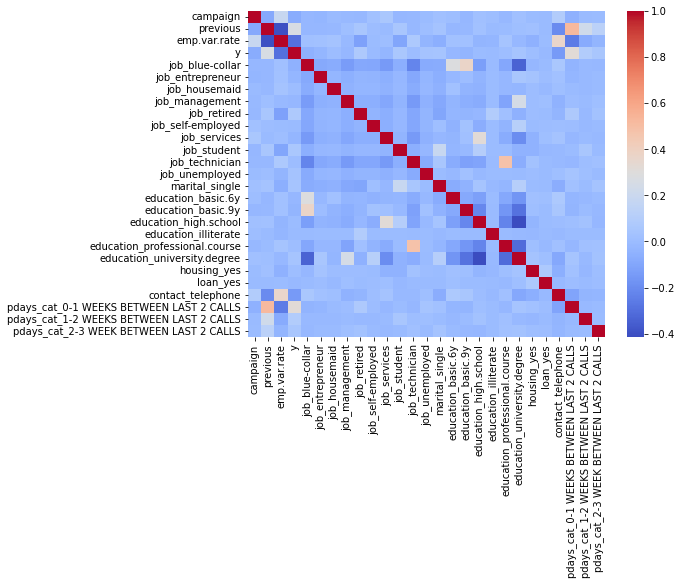

In [5]:
# REMOVE CORRELATED VARIABLES
corr_mar = df_bank.corr()
plt.figure(figsize=(8,6))
sns.heatmap(
    corr_mar,
    cmap = 'coolwarm'
)
plt.show()

## Store results in this list

In [6]:
# we will use this dictionary to store our results.
dict_results_lists = []

## Logistic Regression Dealing with Unbalanced Data:  ___Thresholding___

In [7]:
# Train test split
X = df_bank.drop('y',axis=1)
X = sm.add_constant(X)
y = df_bank['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
# Create your Logistic Regression model
full_threshold_model = LogisticRegression(max_iter=10000)

# Fit the model to your data
full_threshold_model.fit(X, y)

LogisticRegression(max_iter=10000)

#### Feature Selection: AIC

In [9]:
import itertools
from tqdm import tqdm

feature_sets = []
feature_names = [col for col in df_bank.columns if col != 'y']

# Total number of iterations
total_iterations = sum(1 for L in range(1, 5) for _ in itertools.combinations(feature_names, L))

# Create tqdm instance
pbar = tqdm(total=total_iterations, desc="Feature Set Combinations")

for L in range(1, 5):  # Change '7' to a different number if you want more features in the combinations
    for subset in itertools.combinations(feature_names, L):
        feature_sets.append(list(subset))
        pbar.update(1)  # Update progress bar

pbar.close()  # Close progress bar after loop completes

best_aic, best_features = select_model_by_aic(X, y, feature_sets)
print(f"Best AIC Score: {best_aic}")
print(f"Best Feature Set: {best_features}")

Feature Set Combinations: 100%|██████████| 17901/17901 [00:00<00:00, 1277517.12it/s]


Best AIC Score: -6889.145429013685
Best Feature Set: ['emp.var.rate', 'job_blue-collar', 'loan_yes', 'pdays_cat_0-1 WEEKS BETWEEN LAST 2 CALLS']


In [10]:
best_features.append('y')

In [11]:
df_keep = df_bank.drop(columns=df_bank.columns.difference(best_features))

X = df_keep.drop('y', axis=1)
X = sm.add_constant(X)
y = df_keep['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create your Logistic Regression model
subset_threshold_model = LogisticRegression(max_iter=10000)

# Fit the model to your data
subset_threshold_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

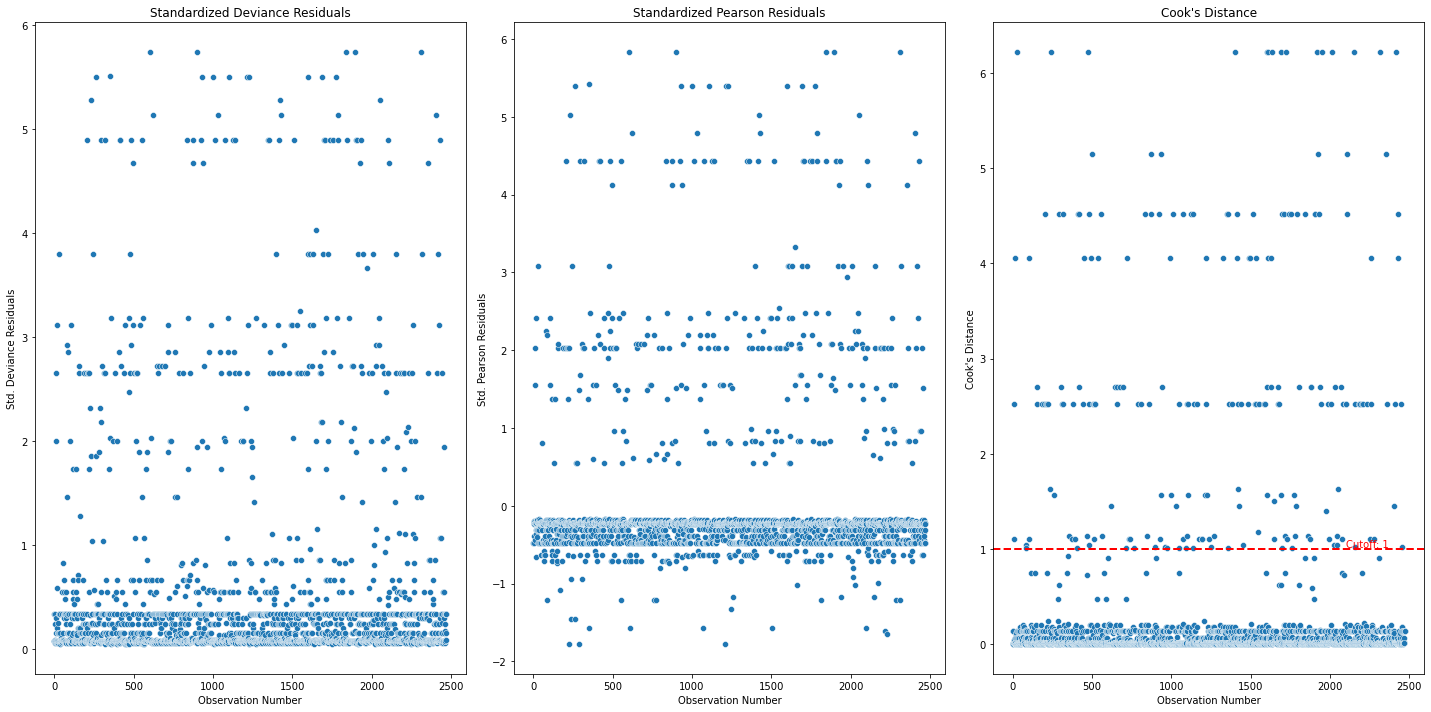

In [12]:
cookd_cutoff = 1
logistic_regression_diagnostic_plots(X_train, y_train, subset_threshold_model,cookd_cutoff)

In [13]:
# Calculate Cook's distance for the observations
cooks_d = calculate_cooks_distance(X_train, y_train, subset_threshold_model)

# Identify observations with Cook's distance greater than the threshold
high_influence_points = cooks_d >= cookd_cutoff

# Get the indices of the observations to be removed
indices_to_remove = np.where(high_influence_points)[0]

# Ensure that the indices to remove are valid
valid_indices_to_remove = set(indices_to_remove).intersection(X_train.index)

# Now drop the rows with the valid indices from the Cook's distance calculation
X_train_filtered = X_train.drop(index=valid_indices_to_remove)
y_train_filtered = y_train.drop(index=valid_indices_to_remove)

# Wrap the AIC scoring function to make it compatible with scikit-learn
# Assuming 'aic_scorer' is a defined function and 'make_scorer' is imported from sklearn.metrics

# Create your Logistic Regression model
subset_threshold_model_filtered = LogisticRegression(max_iter=10000)

# Fit the model to your filtered data
subset_threshold_model_filtered.fit(X_train_filtered, y_train_filtered)

LogisticRegression(max_iter=10000)

In [14]:
subset_threshold_preds = subset_threshold_model_filtered.predict(X_test)
subset_threshold_probs = subset_threshold_model_filtered.predict_proba(X_test)
subset_threshold_metrics, subset_threshold_cm = evaluate(subset_threshold_preds, y_test)
subset_threshold_metrics['name'] = 'subset_threshold_model'

In [15]:
subset_threshold_cm

,PredDown,PredUp
ActDown,540,6
ActUp,62,10


In [16]:
for k, v in subset_threshold_metrics.items():
    if isinstance(v, float):  # Check if the value is a float
        print(f'{k}: {v:.3f}')  # Format float with three decimal places
    else:
        print(f'{k}: {v}')  # Print string as is

sensitivity: 0.139
specificity : 0.989
accuracy: 0.890
name: subset_threshold_model


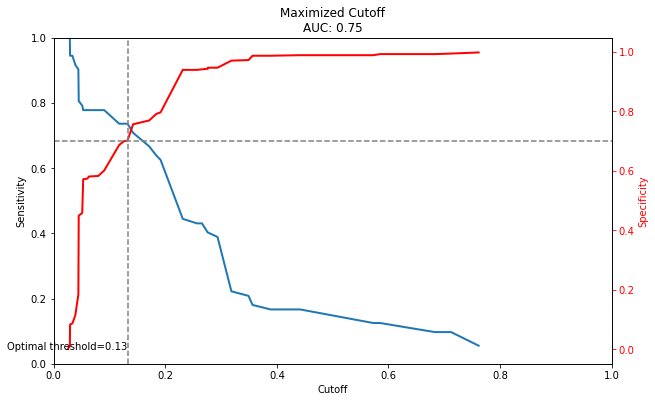

In [17]:
plot_sensitivity_specificity(y_test.values, subset_threshold_probs[:,1])

In [18]:
optimal_threshold = .13
optimal_threshold_preds = []
for item in subset_threshold_probs[:,1]:
    if item >= optimal_threshold:
        optimal_threshold_preds.append(1)
    else:
        optimal_threshold_preds.append(0)

optimal_threshold_metrics, optimal_threshold_cm = evaluate(optimal_threshold_preds, y_test.values)
optimal_threshold_metrics['name'] = 'full_optimal_threshold'
dict_results_lists.append(optimal_threshold_metrics)
optimal_threshold = .13
optimal_threshold_preds = []
for item in subset_threshold_probs[:,1]:
    if item >= optimal_threshold:
        optimal_threshold_preds.append(1)
    else:
        optimal_threshold_preds.append(0)

optimal_threshold_metrics, optimal_threshold_cm = evaluate(optimal_threshold_preds, y_test.values)
optimal_threshold_metrics['name'] = 'full_optimal_threshold'
dict_results_lists.append(optimal_threshold_metrics)
optimal_threshold_cm


,PredDown,PredUp
ActDown,383,163
ActUp,19,53


In [19]:
for k, v in optimal_threshold_metrics.items():
    if isinstance(v, float):  # Check if the value is a float
        print(f'{k}: {v:.3f}')  # Format float with three decimal places
    else:
        print(f'{k}: {v}')  # Print string as is

sensitivity: 0.736
specificity : 0.701
accuracy: 0.706
name: full_optimal_threshold


In [20]:
view_logistic_regression_coefficients(subset_threshold_model_filtered, X_train_filtered)

                                    Feature  Coefficient
4  pdays_cat_0-1 WEEKS BETWEEN LAST 2 CALLS     1.783930
1                              emp.var.rate    -0.510537
2                           job_blue-collar    -0.440218
3                                  loan_yes    -0.137921
0                                     const    -0.005304
Intercept: -2.3533220425598076


## Logistic Regression Dealing with Unbalanced Data: ___Trimming Data___

#### Lets reset the data but this time ___up front___ split the data

In [21]:
# load data again
df_bank = pd.read_csv('./data/bank-additional.csv', sep=';', na_values=['unknown'])

# Convert the target variable 'y' to binary (1 for 'yes', 0 for 'no')
df_bank['y'] = df_bank['y'].map(lambda x: 1 if x.lower() == 'yes' else 0)

# grab pos and neg examples
positive_samples = df_bank[df_bank['y'] == 1]  # Select all rows where 'y' is 1
negative_samples = df_bank[df_bank['y'] == 0]  # Select all rows where 'y' is 0

# Randomly sample 451 rows where 'y' is 0
random_negative_samples = negative_samples.sample(n=451, random_state=42)

# Combine the positive and negative samples
df_bank = pd.concat([positive_samples, random_negative_samples])

# Convert 'pdays' to a categorical column based on specified bins
df_bank['pdays_cat'] = pd.cut(
    df_bank['pdays'], 
    bins=[-float('inf'), 0, 7, 14, 21, float('inf')],
    labels=[
        'NEVER CALLED OR ONLY CALLED ONCE',
        '0-1 WEEKS BETWEEN LAST 2 CALLS',
        '1-2 WEEKS BETWEEN LAST 2 CALLS',
        '2-3 WEEK BETWEEN LAST 2 CALLS',
        'MORE THAN 3 WEEKS BETWEEN LAST 2 CALLS'
    ]
)

# Drop columns that will not be used in the VIF calculation
df_bank.drop(columns=['default', 'duration', 'pdays', 'month', 'day_of_week'], inplace=True)

# Convert categorical columns to dummy variables, excluding the first category to avoid multicollinearity
categorical_cols = ["job", "marital", "education", "housing", "loan", "contact", "poutcome", "pdays_cat"]
df_bank = pd.get_dummies(df_bank, columns=categorical_cols, drop_first=True)

X = df_bank.drop(columns='y')
X = sm.add_constant(X)

y = df_bank['y']

# Initial VIF calculation for all predictors
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# THESE ARE SLIGHTLY DIFFERENT THAN THEY WERE WITH THE WHOLE DATASET
columns_to_drop = [
    'nr.employed',
    'cons.price.idx',
    'pdays_cat_MORE THAN 3 WEEKS BETWEEN LAST 2 CALLS',
    'euribor3m',
    'cons.conf.idx',
    'age',
    'pdays_cat_0-1 WEEKS BETWEEN LAST 2 CALLS',
    'poutcome_nonexistent',
     'marital_married'
]

for column in columns_to_drop:
    X_modified = X.drop(columns=column)  # Drop the specified column
    vif_data_modified = pd.DataFrame({
        'feature': X_modified.columns,
        'VIF': [variance_inflation_factor(X_modified.values, i) for i in range(X_modified.shape[1])]
    })
    X = X_modified  # Update X to exclude the dropped column for the next iteration

# Display the final VIF values after all modifications
print(vif_data_modified)

# set df_bank without the correlated vars
df_bank = df_bank.drop(columns_to_drop, axis=1)
X = df_bank.drop(columns='y')
X = sm.add_constant(X)
y = df_bank['y']

                                     feature        VIF
0                                      const  17.914011
1                                   campaign   1.073732
2                                   previous   1.836732
3                               emp.var.rate   1.525835
4                            job_blue-collar   2.186959
5                           job_entrepreneur   1.103174
6                              job_housemaid   1.133651
7                             job_management   1.219682
8                                job_retired   1.301522
9                          job_self-employed   1.114266
10                              job_services   1.344933
11                               job_student   1.205829
12                            job_technician   1.686568
13                            job_unemployed   1.131271
14                            marital_single   1.179281
15                        education_basic.6y   1.391959
16                        education_basic.9y   1

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [23]:
# Create your Logistic Regression model
trimmed_log_model = LogisticRegression(max_iter=10000)

# Fit the model to your data
trimmed_log_model.fit(X, y)

LogisticRegression(max_iter=10000)

#### Feature Selection AIC

In [24]:
import itertools
from tqdm import tqdm

feature_sets = []
feature_names = [col for col in df_bank.columns if col != 'y']

# Total number of iterations
total_iterations = sum(1 for L in range(1, 5) for _ in itertools.combinations(feature_names, L))

# Create tqdm instance
pbar = tqdm(total=total_iterations, desc="Feature Set Combinations")

for L in range(1, 5):  # Change '7' to a different number if you want more features in the combinations
    for subset in itertools.combinations(feature_names, L):
        feature_sets.append(list(subset))
        pbar.update(1)  # Update progress bar

pbar.close()  # Close progress bar after loop completes

best_aic, best_features = select_model_by_aic(X, y, feature_sets)
print(f"Best AIC Score: {best_aic}")
print(f"Best Feature Set: {best_features}")

Feature Set Combinations: 100%|██████████| 15275/15275 [00:00<00:00, 1173879.47it/s]


Best AIC Score: -1132.0122421759213
Best Feature Set: ['campaign', 'emp.var.rate', 'job_entrepreneur', 'job_housemaid']


In [25]:
best_features.append('y')
df_keep = df_bank.drop(columns=df_bank.columns.difference(best_features))

X = df_keep.drop('y', axis=1)
X = sm.add_constant(X)
y = df_keep['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Create your Logistic Regression model
subset_trimmed_model = LogisticRegression(max_iter=10000)

# Fit the model to your data
subset_trimmed_model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

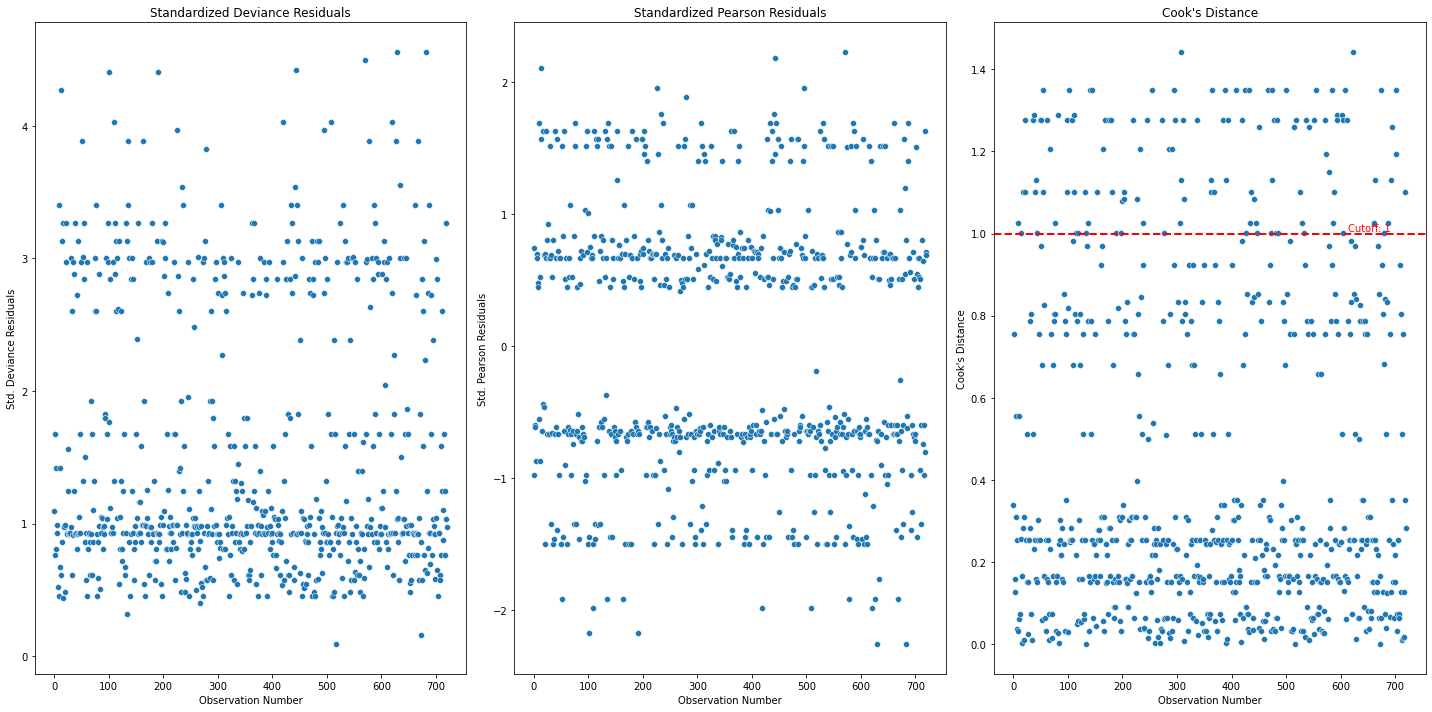

In [26]:
cookd_cutoff = 1
logistic_regression_diagnostic_plots(X_train, y_train, subset_trimmed_model,cookd_cutoff)

In [27]:
# Calculate Cook's distance for the observations
cooks_d = calculate_cooks_distance(X_train, y_train, subset_trimmed_model)

# Identify observations with Cook's distance greater than the threshold
high_influence_points = cooks_d >= cookd_cutoff

# Get the indices of the observations to be removed
indices_to_remove = np.where(high_influence_points)[0]

# Ensure that the indices to remove are valid
valid_indices_to_remove = set(indices_to_remove).intersection(X_train.index)

# Now drop the rows with the valid indices from the Cook's distance calculation
X_train_filtered = X_train.drop(index=valid_indices_to_remove)
y_train_filtered = y_train.drop(index=valid_indices_to_remove)

# Wrap the AIC scoring function to make it compatible with scikit-learn
# Assuming 'aic_scorer' is a defined function and 'make_scorer' is imported from sklearn.metrics

# Create your Logistic Regression model
subset_trimmed_model_filtered = LogisticRegression(max_iter=10000)

# Fit the model to your filtered data
subset_trimmed_model_filtered.fit(X_train_filtered, y_train_filtered)

LogisticRegression(max_iter=10000)

In [45]:
view_logistic_regression_coefficients(subset_trimmed_model_filtered,X_train_filtered)

            Feature  Coefficient
3  job_entrepreneur    -0.741267
2      emp.var.rate    -0.524977
4     job_housemaid     0.228158
1          campaign    -0.086925
0             const    -0.009931
Intercept: -0.014331824316355078


In [28]:
subset_trimmed_preds = subset_trimmed_model_filtered.predict(X_test)
subset_trimmed_probs = subset_trimmed_model_filtered.predict_proba(X_test)
subset_trimmed_metrics, subset_trimmed_cm = evaluate(subset_trimmed_preds, y_test)
subset_trimmed_metrics['name'] = 'subset_trimmed'
dict_results_lists.append(subset_trimmed_metrics)

In [29]:
subset_trimmed_cm

,PredDown,PredUp
ActDown,69,27
ActUp,25,60


In [30]:
for k, v in subset_trimmed_metrics.items():
    if isinstance(v, float):  # Check if the value is a float
        print(f'{k}: {v:.3f}')  # Format float with three decimal places
    else:
        print(f'{k}: {v}')  # Print string as is

sensitivity: 0.706
specificity : 0.719
accuracy: 0.713
name: subset_trimmed


#### Lets compare to the optimal cutoff

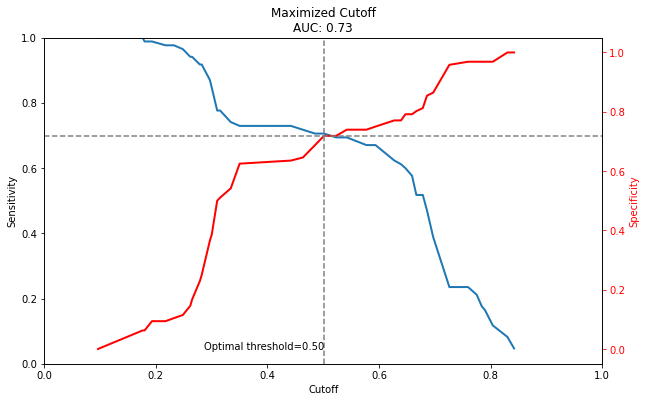

In [31]:
# Exactly .5! Booya!
plot_sensitivity_specificity(y_test, subset_trimmed_probs[:,1])

## LDA

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
lda = lda()
lda.fit(X_train_scaled,y_train)

X_test_scaled = scaler.transform(X_test)
lda_preds = lda.predict(X_test_scaled)

In [33]:
lda_res, lda_res_cm = evaluate(lda_preds, y_test)
lda_res['name'] = 'LDA'
dict_results_lists.append(lda_res)

In [34]:
lda_res_cm

,PredDown,PredUp
ActDown,71,25
ActUp,26,59


In [35]:
for k, v in lda_res.items():
    print(f'{k}: {v:.3}')

sensitivity: 0.694
specificity : 0.74
accuracy: 0.718
name: LDA


## QDA Trimmed

In [36]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train)
qda_preds = qda.predict(X_test_scaled)

C:\Users\dansc\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:960: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:960: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
C:\Users\dansc\anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:963: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


In [37]:
qda_res, qda_res_cm = evaluate(qda_preds, y_test)
qda_res['name'] = 'QDA'
dict_results_lists.append(qda_res)

In [38]:
qda_res_cm

,PredDown,PredUp
ActDown,96,0
ActUp,85,0


In [39]:
for k, v in qda_res.items():
    print(f'{k}: {v:.3}')

sensitivity: 0.0
specificity : 1.0
accuracy: 0.53
name: QDA


In [40]:
results_df = pd.DataFrame(dict_results_lists)

In [41]:
results_df.sort_values('sensitivity', ascending=False, inplace=True) # KI JEONG UPDATE THIS STRING TO REORDER TABLE BY METRIC

In [42]:
results_df.keys()

Index(['sensitivity', 'specificity ', 'accuracy', 'name'], dtype='object')

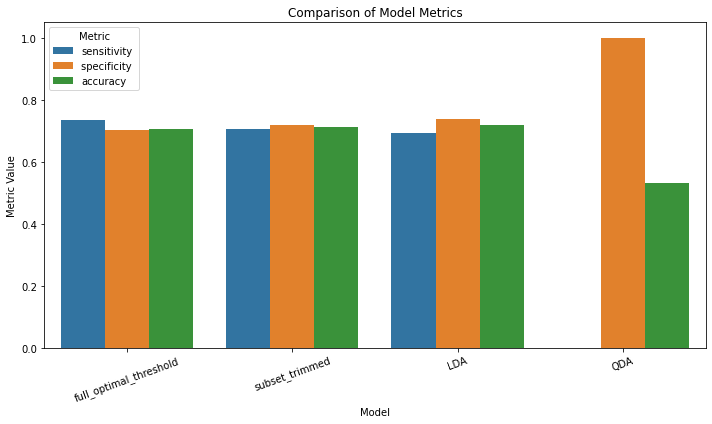

In [43]:
# Correcting the 'value_vars' parameter to match the DataFrame's column names
df_long = pd.melt(
    results_df,
    id_vars='name',
    value_vars=['sensitivity', 'specificity ', 'accuracy'],
    var_name='Metric',
    value_name='Value'
)
# Note the space in 'specificity ' to match the DataFrame's column name

# Continue with the plotting as before
plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x='name', y='Value', hue='Metric')

plt.xticks(rotation=20)  # Rotate x-axis labels for better readability
plt.title('Comparison of Model Metrics')
plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.legend(title='Metric')

plt.tight_layout()
plt.show()